# The Skip-gram Model

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /home/kienmn/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /home/kienmn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kienmn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing the text

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
from nltk.corpus import gutenberg
from string import punctuation

In [5]:
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Implementing the Skip-gram Model
### Build the corpus vocabulary

In [6]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [7]:
wids[:10]

[[13, 1154, 5766],
 [154, 2450, 13, 1154, 5766],
 [132, 310, 63, 86, 8480],
 [582, 6, 1180, 94, 47],
 [47, 136, 1883, 1884, 396, 10, 144, 860],
 [111, 6, 759, 10, 144, 212],
 [6, 8, 27, 232, 232],
 [6, 101, 232, 75, 6, 826, 232, 396],
 [6, 86, 232, 23, 396, 86, 197],
 [926, 287, 132, 23]]

### Building a skip-gram [(target, context), relevancy] generator

In [8]:
from keras.preprocessing.sequence import skipgrams

# Generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

In [9]:
skip_grams[0]

([[5766, 1154],
  [1154, 13],
  [5766, 325],
  [1154, 954],
  [13, 1154],
  [13, 3656],
  [13, 1027],
  [13, 5766],
  [5766, 11041],
  [1154, 3553],
  [1154, 5766],
  [5766, 13]],
 [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1])

In [10]:
# View sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(id2word[pairs[i][0]], pairs[i][0], id2word[pairs[i][1]], pairs[i][1], labels[i]))

(bible (5766), james (1154)) -> 1
(james (1154), king (13)) -> 1
(bible (5766), manner (325)) -> 0
(james (1154), endureth (954)) -> 0
(king (13), james (1154)) -> 1
(king (13), enmity (3656)) -> 0
(king (13), countenance (1027)) -> 0
(king (13), bible (5766)) -> 1
(bible (5766), ambushes (11041)) -> 0
(james (1154), saluted (3553)) -> 0


### Building the Skip-Gram model architecture

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dot, Dense, Embedding, Reshape, Input

In [12]:
input_word = Input((1,))
input_context = Input((1,))

embedding_layer = Embedding(vocab_size, embed_size, input_length=1)

word_embedding = embedding_layer(input_word)
word_embedding = Reshape((embed_size,))(word_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = Reshape((embed_size,))(context_embedding)

hidden_layer = Dot(axes=-1)([word_embedding, context_embedding])
hidden_layer = Reshape((1,))(hidden_layer)

output = Dense(1, input_shape=(1,), activation='sigmoid')(hidden_layer)

model = Model(inputs=[input_word, input_context], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1242500     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100)          0           embedding_1[0][0]          

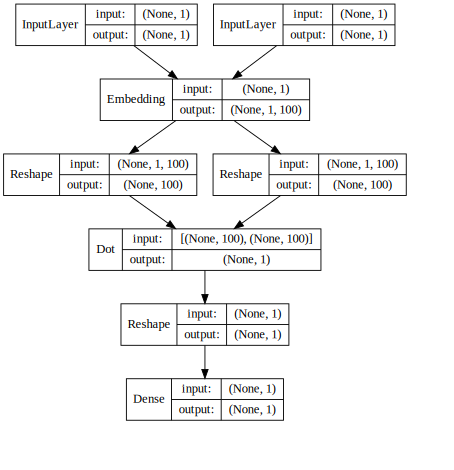

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='TB', dpi=65).create(prog='dot', format='svg'))

### Training the model

In [15]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs


/home/kienmn/Workspace/JupyterWorkspace/jupyter_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 15035.370395410806
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 14942.532208044082
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 14998.210070537403
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 15105.65146959573
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 15228.867030989379


### Getting word embeddings

In [16]:
weights = model.get_weights()[0]
weights = weights[1:]   # weights[0] is PAD.
weights.shape

(12424, 100)

In [17]:
pd.DataFrame(weights, index=list(id2word.values())[:-1]).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
shall,2.172062,4.022445,4.379743,-2.919447,2.543513,-2.867181,-3.250595,-5.386068,-1.919947,3.977858,...,-2.866533,2.387784,-3.274547,4.273549,-2.903743,-5.360615,-4.507411,3.395684,-3.224523,-2.785613
unto,4.453259,3.960287,3.825125,-3.467037,3.959281,-3.300422,-3.786019,-3.892823,-4.615819,2.471072,...,-2.811932,2.544828,-3.603465,3.651397,-3.675355,-2.267075,-3.608488,3.720096,-3.416026,-2.211873
lord,3.865193,3.783848,4.531088,-3.289522,3.603434,-3.337317,-3.525669,-4.333025,-4.063393,2.804844,...,-2.823969,2.823605,-3.426798,3.741462,-3.577426,-3.422535,-4.096468,3.536601,-3.168930,-3.237899
thou,2.842548,3.954312,2.442059,-1.534369,-3.406535,-4.383479,-4.063610,-4.970333,-2.759584,3.492296,...,-3.053588,0.885186,-3.155481,4.654155,-4.590189,-4.066289,-4.471157,1.728781,-3.079309,4.009254
thy,3.128451,3.828587,3.381230,-2.033289,0.668314,-4.314845,-3.702460,-4.603981,-2.760511,3.556735,...,-3.252931,1.638627,-3.257481,4.181323,-4.134443,-4.197641,-4.281988,2.694558,-3.337043,0.053182


### Finding similar words

In [18]:
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(weights)
distance_matrix.shape

(12424, 12424)

In [19]:
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

{'god': ['lord', 'us', 'say', 'let', 'ye'],
 'jesus': ['speak', 'spirit', 'law', 'yea', 'voice'],
 'noah': ['baskets', 'lad', 'mire', 'circumcise', 'sisters'],
 'egypt': ['brought', 'together', 'commanded', 'spake', 'left'],
 'john': ['chambers', 'helped', 'visited', 'making', 'enquired'],
 'gospel': ['ere', 'lighted', 'decree', 'proclaimed', 'clave'],
 'moses': ['commanded', 'spake', 'jacob', 'elders', 'first'],
 'famine': ['thither', 'present', 'clothes', 'wept', 'moab']}

### Visualizing 

Total words: 48 	Word Embedding shapes: (48, 100)


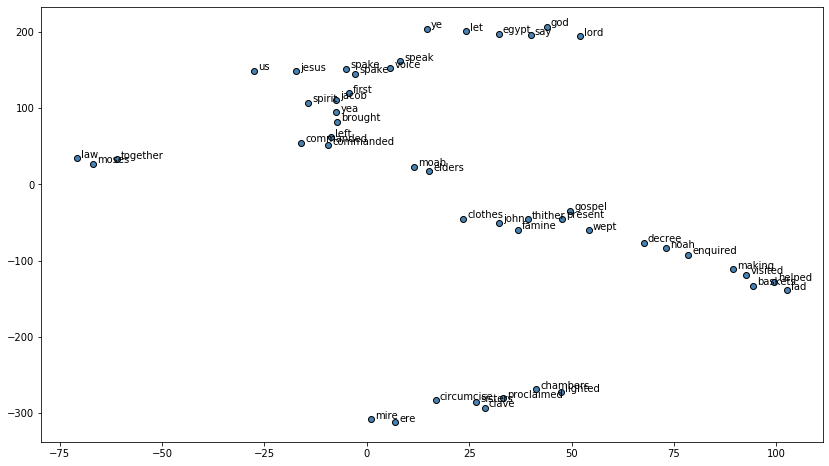

In [20]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Robust Word2Vec Models with Gensim

In [26]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count=min_word_count,
                              sample=sample, iter=50)

In [27]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'sworn', 'glory', 'ever', 'worldly'],
 'jesus': ['peter', 'messias', 'apostles', 'immediately', 'john'],
 'noah': ['shem', 'ham', 'japheth', 'enosh', 'kenan'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'rid', 'rod'],
 'john': ['baptist', 'james', 'simon', 'devine', 'galilee'],
 'gospel': ['faith', 'christ', 'repentance', 'preach', 'afflictions'],
 'moses': ['congregation', 'children', 'joshua', 'ordinance', 'aaron'],
 'famine': ['pestilence', 'peril', 'sword', 'deaths', 'noisome']}

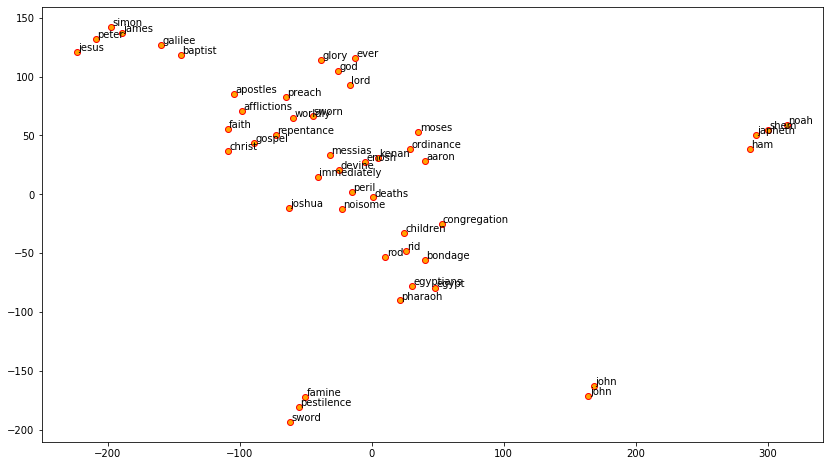

In [28]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [24]:
words[:5]

['god', 'lord', 'worldly', 'soberly', 'salvation']

In [25]:
wvs.shape

(48, 100)